## Week 4 Day 4 - preparing the big project!

# The Sidekick

It's time to introduce:

1. Structured Outputs
2. A multi-agent flow

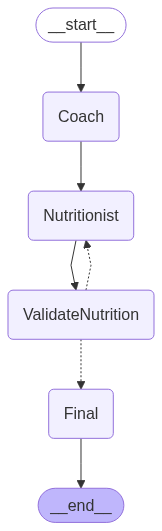

* Running on local URL:  http://127.0.0.1:7880
* Running on public URL: https://5adc5689c51331764a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict
from langchain_core.runnables import RunnableLambda
from IPython.display import Image, display
import gradio as gr

# LLM
llm = ChatOpenAI(model="gpt-4o")

# Estado
class State(TypedDict):
    task: str
    coach_response: str
    nutrition_response: str
    nutrition_validation: str
    final_summary: str

# Nodo: Coach
def coach_agent(state: State) -> State:
    prompt = f"""Sos un entrenador personal costarricense.
Analizá este input y generá recomendaciones físicas y de estilo de vida para que un nutricionista pueda crear un plan:

{state['task']}"""
    result = llm.invoke(prompt)
    state["coach_response"] = result.content
    return state

# Nodo: Nutricionista
def nutritionist_agent(state: State) -> State:
    prompt = f"""Sos un nutricionista clínico con experiencia internacional.

Tu tarea es diseñar 3 planes alimenticios diarios distintos, adaptados al país o región del usuario, respetando su estilo de vida y necesidades metabólicas.

📌 Información base:
{state['coach_response']}

🎯 Objetivo:
Generar 3 menús distintos (Día 1, 2 y 3), cada uno con:
- Almuerzo
- Merienda post-entreno
- Cena

Consideraciones:
- Adaptá la gastronomía a la nacionalidad o preferencia cultural del usuario.
- Respetá ayuno intermitente (por ejemplo, omitir desayuno si aplica).
- Considerá alergias, intolerancias o estilo de vida.
- No repetir platillos entre días.
- Nada ultra procesado.
- Usá medidas claras (gramos, cucharadas, etc.).

Formato por comida:
1. Nombre del platillo
2. Ingredientes con cantidades
3. Preparación resumida
4. Resumen de macros (Proteínas, Carbohidratos, Grasas, Calorías)

📊 Al final de cada día, agregá:
- Tabla resumen con macros totales

Redactá en español, claro, útil para un usuario final.
"""
    result = llm.invoke(prompt)
    state["nutrition_response"] = result.content
    return state

# Nodo: Validador profesional
def nutrition_plan_validator(state: State) -> State:
    prompt = f"""Sos un evaluador profesional de planes nutricionales.

Evaluá este plan generado por un nutricionista:

{state['nutrition_response']}

📋 Verificá:
- ¿Tiene lógica nutricional y cultural?
- ¿Cumple macros, ayuno y claridad para el usuario?
- ¿Está redactado de forma profesional y aplicable?

🔍 Iniciá tu respuesta con una de estas opciones:
- Resultado: Aprobado ✅
- Resultado: Ajustar ⚠️

Luego explicá tu decisión de forma breve y profesional.
"""
    result = llm.invoke(prompt)
    state["nutrition_validation"] = result.content
    return state


# Decisión: ¿Rehacer nutricionista?
def should_repeat_nutri(state: State) -> str:
    val = state["nutrition_validation"].lower()
    if "ajustar" in val or "corregir" in val or "no cumple" in val or "error" in val:
        return "Nutritionist"
    return "Final"

# Nodo: Resumen final
def final_summary(state: State) -> State:
    prompt = f"""📋 Resumen del Plan Nutricional

🧠 Output del coach:
{state['coach_response']}

🥦 Plan del nutricionista:
{state['nutrition_response']}

🔎 Evaluación profesional:
{state['nutrition_validation']}

✨ Frase final:
Recordá, no se trata de cambiar todo en un día… se trata de mejorar 1% cada día. 💪

Convertí esto en un texto estilo Markdown para mostrar al usuario final.
"""
    result = llm.invoke(prompt)
    state["final_summary"] = result.content
    return state

# Construcción del grafo
builder = StateGraph(State)
builder.add_node("Coach", RunnableLambda(coach_agent))
builder.add_node("Nutritionist", RunnableLambda(nutritionist_agent))
builder.add_node("ValidateNutrition", RunnableLambda(nutrition_plan_validator))
builder.add_node("Final", RunnableLambda(final_summary))

builder.set_entry_point("Coach")
builder.add_edge("Coach", "Nutritionist")
builder.add_edge("Nutritionist", "ValidateNutrition")
builder.add_conditional_edges("ValidateNutrition", should_repeat_nutri, {
    "Nutritionist": "Nutritionist",
    "Final": "Final"
})
builder.add_edge("Final", END)

graph = builder.compile(checkpointer=MemorySaver())
display(Image(graph.get_graph().draw_mermaid_png()))

# Interfaz Gradio
def run_pipeline(task):
    result = graph.invoke({"task": task}, config={"configurable": {"thread_id": "gradio-run"}})
    return (
        result["coach_response"],
        result["nutrition_response"],
        result["nutrition_validation"],
        result["final_summary"]
    )

with gr.Blocks() as demo:
    gr.Markdown("## 🧠 Nutrición Personalizada con IA (Coach + Nutricionista + Validador)")
    task_input = gr.Textbox(label="📌 Ingresá tu InBody, metas, restricciones, cultura", lines=4)
    run_btn = gr.Button("💡 Generar Plan Nutricional")

    with gr.Row():
        with gr.Column():
            coach_out = gr.Textbox(label="🏋️ Coach", lines=6)
            nutri_out = gr.Textbox(label="🥦 Nutricionista", lines=12)
        with gr.Column():
            valid_out = gr.Textbox(label="✅ Validación profesional", lines=8)
            final_out = gr.Textbox(label="📜 Resumen Final", lines=10)

    run_btn.click(fn=run_pipeline, inputs=[task_input], outputs=[
        coach_out, nutri_out, valid_out, final_out
    ])

demo.launch(share=True)
